# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import time 
import re

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
english_stop_words = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# machine learning

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


from sklearn.metrics import classification_report

import seaborn as sns
sns.set(style ='whitegrid')
pd.set_option('display.max_columns',None)


C:\Users\ARCHI\anaconda3\envs\project-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
headers=['Tweet_ID','Entity','Sentiment','Tweet_content']


train_df=pd.read_csv('twitter_training.csv', sep=',', names=headers)

valid_df=pd.read_csv('twitter_validation.csv', sep=',', names=headers)

# Exploratory Data Analysis

In [3]:
train_df.sample(5)

,Tweet_ID,Entity,Sentiment,Tweet_content
7101,9221,Overwatch,Negative,"overwatch is trash, finish this game"
14287,2849,Dota2,Negative,@ DOTA2 There is a flaw in the ability design....
6223,271,Amazon,Neutral,Amazon Translate ranks at.. t.me / techtldr / ...
71371,11025,TomClancysGhostRecon,Neutral,"Shocked, you could climb up there."
54961,2238,CallOfDuty,Neutral,Call Of Duty WWII ranked Ctf insane comeback c...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       74682 non-null  int64 
 1   Entity         74682 non-null  object
 2   Sentiment      74682 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [5]:
train_df['Sentiment'].value_counts()

Negative      22542
Positive      20832
Neutral       18318
Irrelevant    12990
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

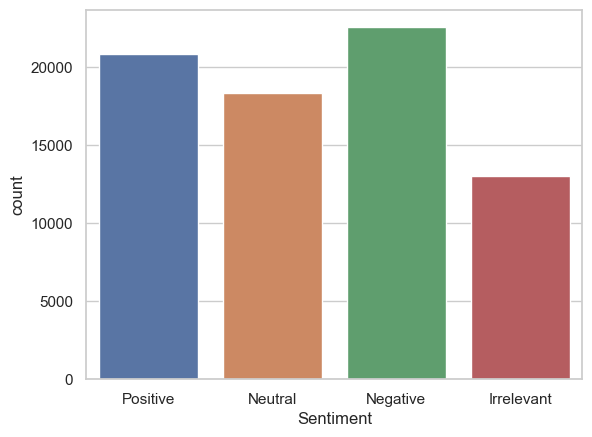

In [6]:
sns.countplot(x=train_df['Sentiment'])

In [7]:
train_df.duplicated().sum()

2700

In [8]:
train_df= train_df.drop_duplicates()

<AxesSubplot:ylabel='Sentiment'>

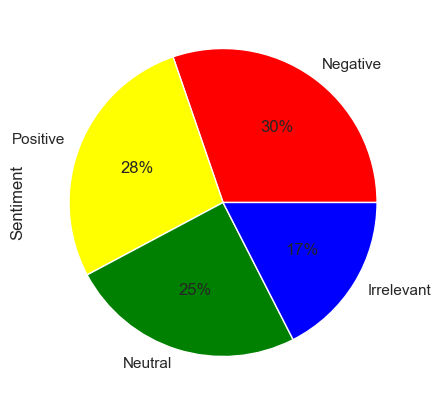

In [9]:
train_df.Sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5),colors=["red", "yellow", "green",'blue'])


<AxesSubplot:xlabel='Entity'>

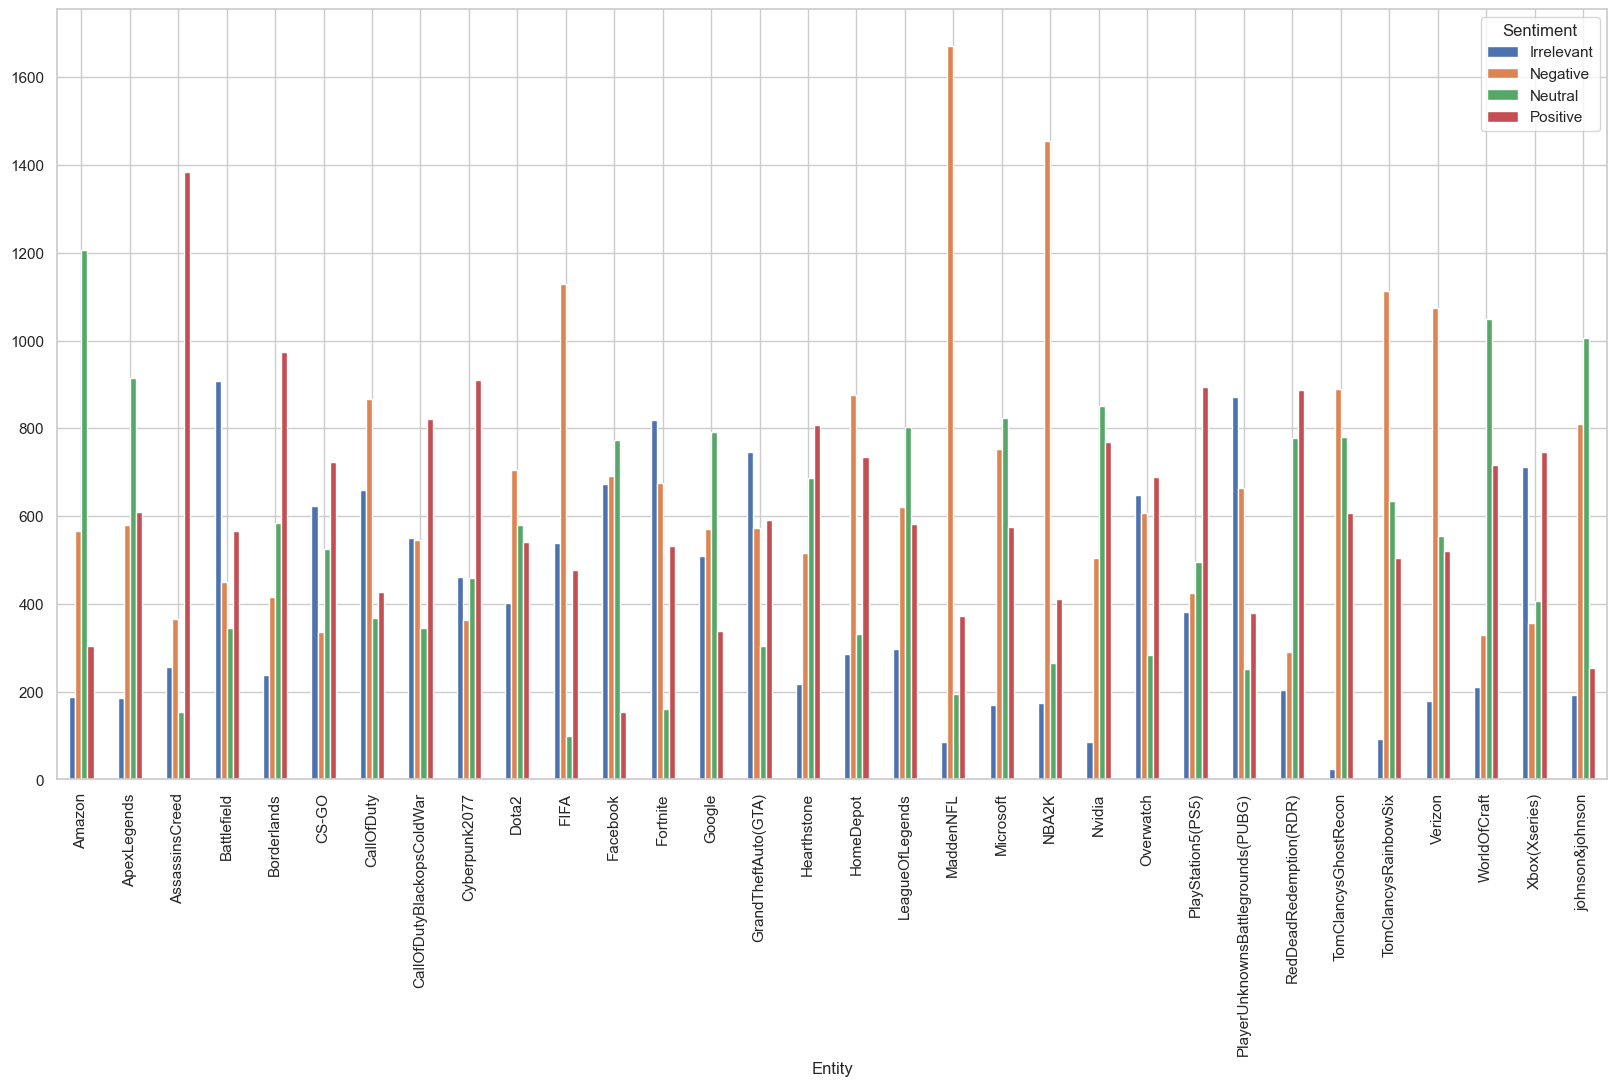

In [10]:
Twitter_sentiment = train_df.groupby(['Entity', 'Sentiment']).Sentiment.count().unstack()
Twitter_sentiment.plot(kind='bar',figsize=(20,10))

# Data Cleaning

In [11]:
# encoder for target feature
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
train_df['Sentiment']=lb.fit_transform(train_df['Sentiment'])

In [12]:
train_df['Tweet_content'].isnull().sum()

326

In [13]:
train_df.dropna(axis=0, inplace=True)

In [14]:
tweet_train  = train_df["Tweet_content"]
tweet_valid=valid_df["Tweet_content"]
target=train_df['Sentiment']

# Step (1): Remove Additional Letter such as @

In [15]:
REPLACE_WITH_SPACE = re.compile("(@)")
SPACE = " "

def preprocess_reviews(reviews):  
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line.lower()) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(tweet_train)
reviews_valid_clean = preprocess_reviews(tweet_valid)

# Step (2): Remove Stop Words

In [16]:
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in english_stop_words]))
    return removed_stop_words

no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_valid = remove_stop_words(reviews_valid_clean)

# Step(3) : Stemming

In [17]:
def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

stemmed_reviews_train = get_stemmed_text(no_stop_words_train)
stemmed_reviews_test = get_stemmed_text(no_stop_words_valid)

# Step(4) : TF-IDF

In [18]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(stemmed_reviews_train)
X = tfidf_vectorizer.transform(stemmed_reviews_train)
X_test = tfidf_vectorizer.transform(stemmed_reviews_test)

# Step(5) : Spliting Data 

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, target, train_size = 0.75)

# Step(6) : Random Forest Model

In [41]:
text_classifier = RandomForestClassifier(n_estimators=300, random_state=0)
text_classifier.fit(X_train, y_train)

y_pred=text_classifier.predict(X_val)
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      3114
           1       0.92      0.93      0.93      5434
           2       0.93      0.90      0.91      4512
           3       0.85      0.94      0.89      4854

    accuracy                           0.91     17914
   macro avg       0.92      0.90      0.91     17914
weighted avg       0.91      0.91      0.91     17914



# XGBoost Model

In [25]:
import xgboost as xgb

In [26]:
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

[19:10:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [33]:
y_pred = xgb_model.predict(X_train)

In [34]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.48      0.61      9423
           1       0.64      0.89      0.75     16264
           2       0.80      0.65      0.71     13196
           3       0.73      0.75      0.74     14859

    accuracy                           0.72     53742
   macro avg       0.75      0.69      0.70     53742
weighted avg       0.74      0.72      0.71     53742



# KNN Model

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [36]:
knn = KNeighborsClassifier(n_neighbors=11)

In [37]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [40]:
knn.score(X_val, y_val)

0.7650999218488334